# Make sentence evaluation sample dataset

We want to sanity check the accuracy of the [ArgumenText](https://api.argumentsearch.com/en/doc) API. One way to do this is spot checks on the results, and using those spot checks to estimate precision and recall.

**Precision**  
Also known as "positive predictive value."  
Out of all of the retrieved instances, how many of them are correctly retrieved/classified?  
For argument mining, this is evaluated by looking at all of the sentences classified as an argument, and verifying how many of them actually contain an argument.

**Recall / Sensitivity**  
Also known as the true positive rate.  
What is the proportion of classified positives given all of the labeled positives. The extend of how often actual positives are not overlooked.
High sensitivity means that a true positive is rarely overlooked. This often comes at a loss of specificity.


**Specificity**  
Also known as the true negative rate.  
What is the proportion of classified negatives given all of the labeled negatives.
High specificity means that a true negative is rarely overlooked.

In [1]:
# reload local package definitions for each cell
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

from dotenv import find_dotenv, load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from arg_mine import DATA_DIR, FIGURES_DIR
from arg_mine.data import loaders, labelers
from arg_mine.api import classify, auth, session, errors
from arg_mine.visualization.plot_utils import make_confusion_matrix, make_roc_curve
from arg_mine import utils
from arg_mine.metrics import summary_stats

SEED = 12345

sns.set_style("whitegrid")

/usr/local/lib/python3.8/site-packages/grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/usr/local/lib/python3.8/site-packages/urllib3/contrib/pyopenssl.py)']. 
  curious_george.patch_all(thread=False, select=False)


In [3]:
# load the 2020 context snippet, for access later
csv_datapath = os.path.join(DATA_DIR, "raw", "2020-climate-change-narrative")
csv_filepath = os.path.join(csv_datapath, "WebNewsEnglishSnippets.2020.csv")

url_df = loaders.get_gdelt_df(csv_filepath)

INFO:2020-07-21 23:53:09,398:arg_mine.data.loaders: reading data from: /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2020.csv


In [4]:
start_time = time.time()
data_processed_project = "gdelt-climate-change-docs"
base_path = os.path.join(DATA_DIR, "processed", data_processed_project)
docs_df = loaders.load_processed_csv("gdelt_2020_docs_docs0-999.csv", data_processed_project)

print("data load took {:0.1f} s".format(time.time() - start_time))

sentences_full_df = loaders.load_processed_csv("gdelt_2020_sentences_docs0-999.csv", data_processed_project, drop_nan_cols='sentence_original')

INFO:2020-07-21 23:53:11,036:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_docs_docs0-999.csv
INFO:2020-07-21 23:53:11,051:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_sentences_docs0-999.csv


data load took 0.0 s


no argument    24701
argument        6750
Name: argument_label, dtype: int64

Total # of sentences: 31451
no argument    0.78538
argument       0.21462
Name: argument_label, dtype: float64


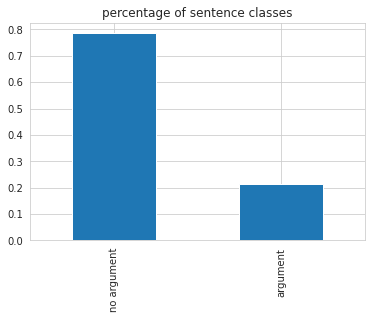

In [5]:
arg_label_counts = sentences_full_df.argument_label.value_counts()
print(arg_label_counts)
print("\nTotal # of sentences: {}".format( sentences_full_df.shape[0]))
class_pct = arg_label_counts / sentences_full_df.shape[0]
print(class_pct)
class_pct.plot(kind="bar")
_ = plt.title("percentage of sentence classes")

# Evaluate the ArgText classification vs human labels

# 600 sentence manual review

We look at 600 sentences with a balanced split between arg/non-arg sentences, 300 of each.
This balanced dataset gives us information of how well the algorithm performs under the assumption of an equal distribution of classes. This, of course, is not true, but it gives us a feel for how the model performs under ideal circumstances.

In [6]:
review_output_filename = "argtext_sentences_manual_review_1k_reviewed600.csv"
review_output_filename = os.path.join(DATA_DIR, "interim", review_output_filename)

reviewed_sent_df = pd.read_csv(review_output_filename)
reviewed_sent_df.dropna(inplace=True)

y_model = reviewed_sent_df.is_arg.astype(int)
y_model_conf = reviewed_sent_df.argument_confidence
y_label = reviewed_sent_df.binarized.astype(int)

stats_balanced = summary_stats(y_label, y_model, y_model_conf, name="balanced classes")
stats_balanced.at['balanced classes', "threshold"] = 0.5
stats_balanced

,accuracy,precision,recall,f1_score,roc_auc,threshold
balanced classes,0.803987,0.827815,0.791139,0.809061,0.881617,0.5


In [7]:
reviewed_sent_df.argument_label.value_counts()

argument       302
no argument    300
Name: argument_label, dtype: int64

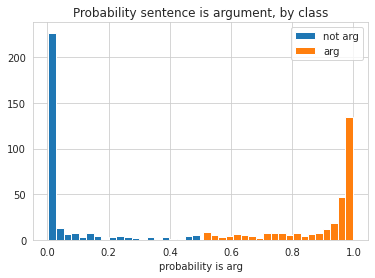

In [8]:
n_bins = 20
fig, ax = plt.subplots()
_ = plt.hist(
    reviewed_sent_df.loc[reviewed_sent_df['argument_label'] == classify.ArgumentLabel.NO_ARGUMENT, 'argument_confidence'],
    bins=n_bins, label='not arg')
_ = plt.hist(
    reviewed_sent_df.loc[reviewed_sent_df['argument_label'] == classify.ArgumentLabel.ARGUMENT, 'argument_confidence'],
    bins=n_bins, label='arg')
plt.xlabel("probability is arg")
plt.title("Probability sentence is argument, by class")
_ = plt.legend()

### Confusion matrix

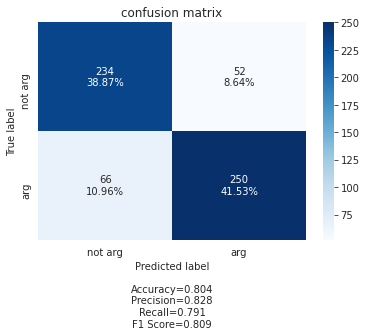

In [9]:
cf_matrix = confusion_matrix(y_label, y_model)
fig = make_confusion_matrix(cf_matrix, categories=["not arg", "arg"], title="confusion matrix")
plt.savefig(os.path.join(FIGURES_DIR, "argtext_validation_600sentence_cm.png"))

Because this dataset is balanced (equal positive and negative samples), we would ideally see the same number on the diagonal, and nothing in the off-diagonal.

What we see is that the false positives (upper right) and false negatives (lower left) are fairly balanced, given a balanced presence of positive and negative sentences in the evaluation set. This may not be the case in the unbalanced "natural" set.

### ROC curve
Typically, we want to have as low of a FPR and as high of a TPR as possible, effectively pushing the curve up and to the left. The unity line denotes random chance for this binomial problem.

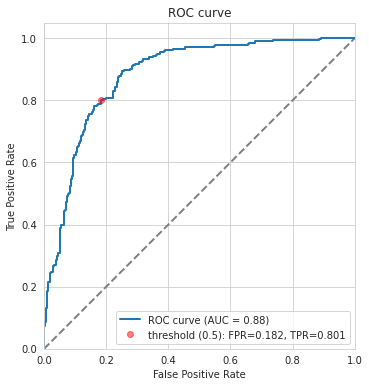

In [10]:
ax = make_roc_curve(y_label, y_model_conf, selected_thresh=0.5)

Note that the False Positive Rate (FPR) and True Positive Rate (TPR) can both be changed by adjusting the threshold used for the binary classification.

If we are willing to have a higher true positive rate at the cost of more false positives, we can decrease the threshold. This will also result in more positive classifications overall.

Below we decrease the threshold to 0.05, which increases the TPR to 90%, and also increases the FPR to 25%. This means that out of all of the sentences that are actually not arguments, 25% of them will be classified as arguments.

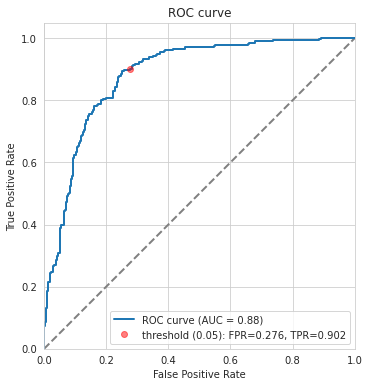

In [11]:
ax = make_roc_curve(y_label, y_model_conf, selected_thresh=0.05)

We can also increase the threshold, which will decrease the FPR rate, but will also decrease the TPR rate.

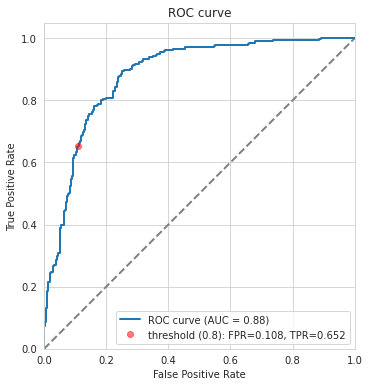

In [12]:
ax = make_roc_curve(y_label, y_model_conf, selected_thresh=0.8)

### Precision Recall
We want both high precision and high recall. 80%/80% can be a reasonable target, without additional tuning on the model training.

High precision is more sentences classified as arguments are actually arguments.  
High recall means out of all of the sentences that are actually arguments, more of them are classified as arguments



In [13]:
precision, recall, thresholds = precision_recall_curve(y_label, y_model_conf)
selected_thresh = 0.5

thresh_ix = np.argmin(np.abs(thresholds-selected_thresh))
thresh_recall = recall[thresh_ix]
thresh_precision = precision[thresh_ix]
print("Default threshold ({}) => recall={:0.2f}, precision={:0.2f}".format(selected_thresh, thresh_recall, thresh_precision))

Default threshold (0.5) => recall=0.79, precision=0.83


Default threshold (0.5) => recall=0.794, precision=0.828


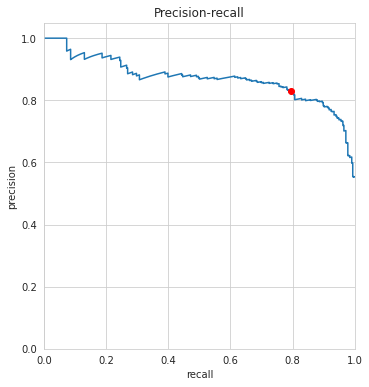

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(recall, precision, label="precision-recall curve")
plt.plot(thresh_recall, thresh_precision, 'ro')
plt.xlim((0, 1.0))
plt.ylim((0, 1.05))
ax.set_aspect('equal', 'box')
plt.xlabel("recall")
plt.ylabel("precision")
_ = plt.title("Precision-recall")
print("Default threshold ({}) => recall={:0.3f}, precision={:0.3f}".format(selected_thresh, thresh_recall, thresh_precision))

# Naturalized sample from 600 sentences
The above analysis was to look at overall recall/precision for a balanced dataset. But the classes aren't balanced. What do these numbers look like if we downsample the `argument` class to match the natural distribution, around 21%.

To do this, we use the ground truth labels to identify which sentences are not arguments vs arguments, and downsample the number of argument sentences to match the expected population ratio (21% positive)


In [15]:
class_pct

no argument    0.78538
argument       0.21462
Name: argument_label, dtype: float64

In [16]:
# sample based on presumed ground truth labels, NOT the prediction

negative_samples = reviewed_sent_df.loc[reviewed_sent_df.binarized == 0]
n_negative = negative_samples.shape[0]
# TODO: simplify this math? There should be an easier formula than (nneg/pct_neg - nneg). nneg*(1/pct_neg - 1)?
n_positive = np.round(n_negative/class_pct['no argument'] - n_negative).astype(int)
total_samples = np.round(n_negative / class_pct['no argument']).astype(int)
positive_samples = reviewed_sent_df.loc[reviewed_sent_df.binarized == 1].sample(n=n_positive)
reviewed_natural_df = pd.concat([negative_samples, positive_samples]).sample(frac=1).reset_index(drop=True)

y_model = reviewed_natural_df.is_arg.astype(int)
y_model_conf = reviewed_natural_df.argument_confidence
y_label = reviewed_natural_df.binarized.astype(int)

stats_natural = summary_stats(y_label, y_model, y_model_conf, name="natural classes")
stats_natural.at['natural classes', "threshold"] = 0.5
stats_natural

,accuracy,precision,recall,f1_score,roc_auc,threshold
natural classes,0.821429,0.555556,0.833333,0.666667,0.896001,0.5


### Confusion matrix

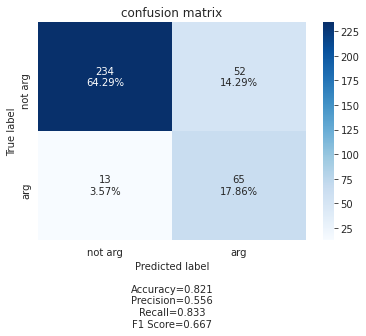

In [17]:
cf_matrix = confusion_matrix(y_label, y_model)

fig = make_confusion_matrix(cf_matrix, categories=["not arg", "arg"], title="confusion matrix")
plt.savefig(os.path.join(FIGURES_DIR, "argtext_validation_382sentence_cm_natural.png"))

We see that the model has a high percentage of false positives in the context of a natural prevalence of arg/not-arg sentences.

As discussed above, this high percentage of false positives could be reduced by increasing the binarizing threshold. This will also in turn affect the precision and recall.

### ROC curve
Typically, we want to have as low of a FPR and as high of a TPR as possible, effectively pushing the curve up and to the left. The unity line denotes random chance for this binomial problem.

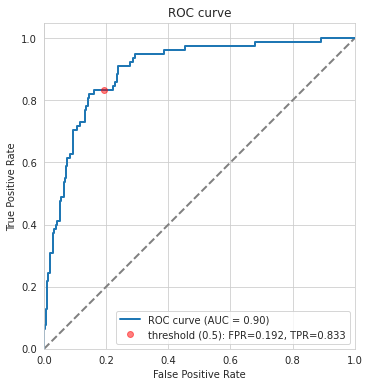

In [18]:
ax = make_roc_curve(y_label, y_model_conf, selected_thresh=0.5)

This curve looks similar to the unbalanced curve, but with fewer positive samples, it is coarser and loses resolution.

### Precision Recall
We want both high precision and high recall. 80%/80% can be a reasonable target, without additional tuning on the model training.

High precision is more sentences classified as arguments are actually arguments.  
High recall means out of all of the sentences that are actually arguments, more of them are classified as arguments



In [19]:
precision, recall, thresholds = precision_recall_curve(y_label, y_model_conf)

In [20]:
thresh_ix = np.argmin(np.abs(thresholds-selected_thresh))
thresh_recall = recall[thresh_ix]
thresh_precision = precision[thresh_ix]
print("Default threshold ({}) => recall={:0.2f}, precision={:0.2f}".format(selected_thresh, thresh_recall, thresh_precision))

Default threshold (0.5) => recall=0.83, precision=0.55


Default threshold (0.5) => recall=0.833, precision=0.551


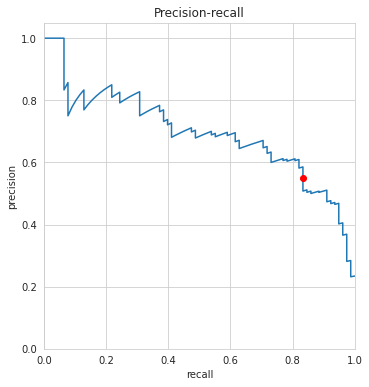

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(recall, precision, label="precision-recall curve")
plt.plot(thresh_recall, thresh_precision, 'ro')
plt.xlim((0, 1.0))
plt.ylim((0, 1.05))
ax.set_aspect('equal', 'box')
plt.xlabel("recall")
plt.ylabel("precision")
_ = plt.title("Precision-recall")
print("Default threshold ({}) => recall={:0.3f}, precision={:0.3f}".format(selected_thresh, thresh_recall, thresh_precision))

# Model comparison

Why are the imbalanced and balanced outcomes so different? Let's first compare the aggregated scores.

In [22]:
model_stats = pd.concat([stats_balanced, stats_natural], axis=0)
model_stats

,accuracy,precision,recall,f1_score,roc_auc,threshold
balanced classes,0.803987,0.827815,0.791139,0.809061,0.881617,0.5
natural classes,0.821429,0.555556,0.833333,0.666667,0.896001,0.5


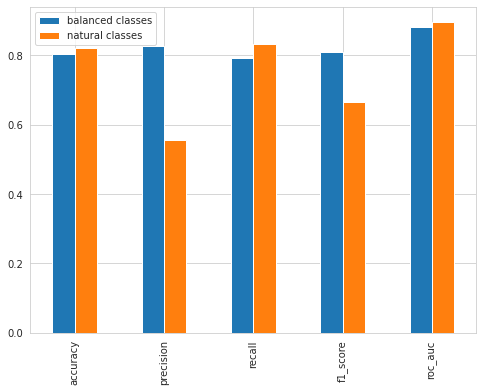

In [23]:
# higher is better for all of these metrics
model_stats.drop("threshold", axis=1).T.plot.bar(figsize=(8,6))